In [1]:
import time
import psycopg2
import datetime
from config import config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

## Establishing connection to Database

In [2]:
conn = None

try:
    # read connection parameters
    params = config()

    # connect to the PostgreSQL server
    print('Connecting to the PostgreSQL database...')
    conn = psycopg2.connect(**params)

    # create a cursor
    cur = conn.cursor()
        
    # execute a statement, display the PostgreSQL database server version
    print('PostgreSQL database version:')
    cur.execute('SELECT version()')
    db_version = cur.fetchone()
    print(db_version)
       
    # execute a statement, fech pv yield
    
    cur.execute(
         """
         SELECT date, yield FROM daily_yield 
         WHERE solarlog_id=3588 AND solarlog_subdomain=%s
         """,
        ('home1',)
        )
    result = cur.fetchall()

    # to fetch Plant id on the basis of selectedis 12241
    cur.execute(
         """
         SELECT id FROM plants 
         WHERE solarlog_id=3588 AND solarlog_subdomain=%s
         """,
        ('home1',)
        )

    plant_id = cur.fetchall()
    
    
    # close the communication with the PostgreSQL
    cur.close()
    
except (Exception, psycopg2.DatabaseError) as error:
    print(error)
    
finally:
    if conn is not None:
        conn.close()
        print('Database connection closed.')

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 13.0 (Debian 13.0-1.pgdg100+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 8.3.0-6) 8.3.0, 64-bit',)
Database connection closed.


In [3]:
print(result[0],plant_id[0][0])

(datetime.date(2020, 7, 19), Decimal('174.00')) 12241


## Data Preparation
Converting SQL values to Dataframe, then convert the time column to datetime column and convert yield to numeric values

In [4]:
import pandas
df= pandas.DataFrame(result, columns=['date','yield'])
print(df)

             date   yield
0      2020-07-19  174.00
1      2020-07-16   40.00
2      2020-07-16    7.00
3      2020-07-19  173.00
4      2020-07-19  163.00
...           ...     ...
51889  2019-12-27   25.00
51890  2019-12-27    0.00
51891  2019-12-27    0.00
51892  2019-12-27    0.00
51893  2019-12-27    0.00

[51894 rows x 2 columns]


In [5]:
df= df.set_index('date')

In [6]:
df.index.freq='D'


In [7]:
print(df.index.freq)

D


In [8]:
#Values of yield is decimal, it's important to convert them to Numeric values to plot graphs etc
import pandas as pd
df["yield"] = pd.to_numeric(df["yield"])

In [9]:
df.head()

,yield
date,
2020-07-19,174.0
2020-07-16,40.0
2020-07-16,7.0
2020-07-19,173.0
2020-07-19,163.0


## Dataframe plotting and correlation plotting

<AxesSubplot:xlabel='date'>

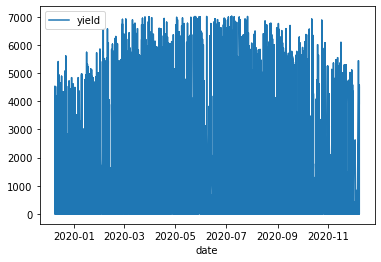

In [10]:
df.plot()

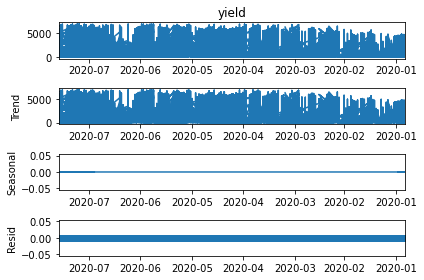

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(df['yield'], model='additive', extrapolate_trend='freq', period=1)

result_add.plot();

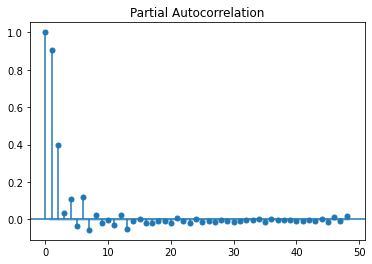

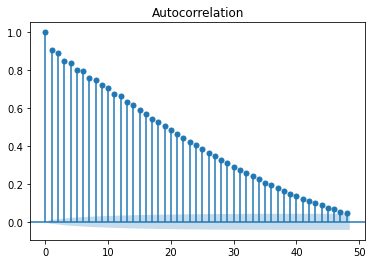

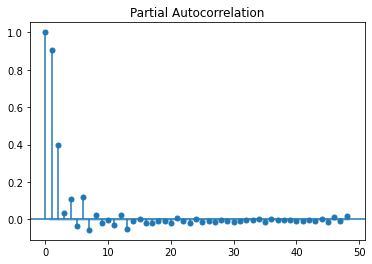

In [12]:
#plot auto correlation and partial correlation
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df)
plot_pacf(df)

## MODEL BUILDING- SARIMAX
Refrence for pdarima- https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
from statsmodels.tsa.arima_model import ARMA,ARIMA, ARMAResults, ARIMAResults

In [19]:
#using pmdarima to determine the best parameters (plag, order, qlag) 
from pmdarima import auto_arima 
auto_arima(df['yield'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                51894
Model:               SARIMAX(5, 1, 5)   Log Likelihood             -417195.136
Date:                Wed, 16 Dec 2020   AIC                         834414.272
Time:                        16:36:57   BIC                         834520.556
Sample:                             0   HQIC                        834447.508
                              - 51894                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0007      0.306     -0.002      0.998      -0.601       0.599
ar.L1         -0.8087      0.020    -39.494      0.000      -0.849      -0.769
ar.L2          0.0568      0.020      2.840      0.005       0.018       0.096
ar.L3          0.8486      0.013     67.603      0.000       0.824       0.873
ar.L4          0.7580      0.014     55.996      0.000       0.731       0.785
ar.L5         -0.0521      0.010     -5.013      0.000      -0.072      -0.032
ma.L1          0.3605      0.021     17.378      0.000       0.320       0.401
ma.L2         -0.3294      0.013    -24.416      0.000      -0.356      -0.303
ma.L3         -0.8435      0.011    -80.151      0.000      -0.864      -0.823
ma.L4         -0.3841      0.013    -30.385      0.000      -0.409      -0.359
ma.L5          0.2678      0.009     30.921      0.000       0.251       0.285
sigma2       5.65e+05   1701.945    332.000      0.000    5.62e+05    5.68e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):            386191.48
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.39
Prob(H) (two-sided):                  0.04   Kurtosis:                        16.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
#taking the best parameters generated on subset of dataset consist of 1 Lacs rows as pmdarima do not work well on large datasets
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df['yield'].values,order=(5,1,5), initialization='approximate_diffuse')
model_fit= model.fit()
rmse = sqrt(mean_squared_error(df['yield'].values,model_fit.fittedvalues)) 
print('Test RMSE: %.3f' % rmse)

Test RMSE: 750.723
